# Reference:

https://www.tensorflow.org/tutorials/images/transfer_learning

# Data Processing

In [ ]:
from matplotlib import image
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip drive/MyDrive/AML_project/train.zip > /dev/null
!unzip drive/MyDrive/AML_project/test.zip > /dev/null

!cp "/content/drive/MyDrive/AML_project/list/train.txt" "train.txt"
!cp "/content/drive/MyDrive/AML_project/list/groundtruth.txt" "groundtruth.txt"

In [ ]:
def convert_image_to_numpy(image_paths_arr):
  dataset_nparr = list()

  for path in image_paths_arr:
    image_data = image.imread(path)
    image_data = tf.cast(image_data, tf.float32)/255
    image_data = tf.image.resize(image_data, (128, 128), method = "bilinear")
    dataset_nparr.append(image_data)

  return np.array(dataset_nparr)

In [ ]:
def encode_labels(labels_arr):
  label_encoder = LabelEncoder()
  return label_encoder.fit_transform(labels_arr)

In [ ]:
def load_data(text_file):
  with open(text_file) as txt_file:
    # read the file, with format "path label"
    # e.g. train/photo/106023/1769.jpg 106023
    lines_arr = [line.strip() for line in txt_file.readlines()]

    # split the lines to image path and label
    image_paths = [line.split(' ')[0] for line in lines_arr]
    labels = [line.split(' ')[1] for line in lines_arr]

    x_data = convert_image_to_numpy(image_paths)
    y_data = encode_labels(labels)

    return x_data, y_data

In [ ]:
x_train, y_train = load_data("train.txt")

In [ ]:
x_test, y_test = load_data("groundtruth.txt")

In [ ]:
print("Shapes Checking")
print("X-train: " + str(x_train.shape))
print("y-train: " + str(y_train.shape))
print("X-test: " + str(x_test.shape))
print("y-test: " + str(y_test.shape))

Shapes Checking
X-train: (4744, 128, 128, 3)
y-train: (4744,)
X-test: (207, 128, 128, 3)
y-test: (207,)


# Transfer Learning (Pre-Trained Model)

One of the solutions that we can try in order to have a good model without the need to train our own model for a really long time is to use a pre-trained model using transfer learning. A pre-trained model is basically a model that has been structured, trained, and tested using different kind of big dataset thus the model is robust enough to be directly used. A pre-trained model can be simply loaded to a project and get fine-tuned or trained again using the available dataset in order to adjust its knowledge to the dataset that we are working on. In this case, we will utilize the MobileNetV2 pre-trained model to help us in getting better accuracy with less amount of training efforts needed.

In [ ]:
# Load the required libraries
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from matplotlib import image
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, RandomFlip, RandomRotation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras.metrics import TopKCategoricalAccuracy

In [ ]:
# A pre-trained model usually comes with pre-defined format of dataset that is suitable for the model.
# In this case, MobileNetV2 has some size options that we can choose from and in this case we will go with 128x128 size of image
# By that, we will load the dataset again but now, we will use different size of data. The other process is the same as the one that we have worked on before.
# x_train_dataset = list()

# for name in image_name:
#   image_data = image.imread('Train/' + name)
#   image_data = tf.cast(image_data, tf.float32)/255
#   image_data = tf.image.resize(image_data, (128, 128), method= 'bilinear')
#   x_train_dataset.append(image_data)
# train_data = np.array(x_train_dataset)

# y_train_np = np.array(label)
# train_labels = to_categorical(y_train_np)

In [ ]:
# Remember to split the data into 80-20 train-validation dataset so we can know how the model perform later on
# x_train, x_validation, y_train, y_validation = train_test_split(train_data, train_labels, test_size=0.20, random_state=42)

In [ ]:
# Let's the load the pre-trained model. We will utilize our own classification layer (Dense(200)) so we need to exclude the top layer of the pre-trained model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

In [ ]:
# Since we wanted to utilize the weights that have been embedded into the pre-trained model to help us in getting higher accuracy with less training,
# we will need to ensure that we prevent the model from updating its weight when data was fit into the model. The pre-trained model later on will be
# a part of the sequential layer so the layers that will be trained later on will be the extra layers that we add such as the Dense or pooling layer
# while the layers that have been embedded into the pre-trained model must be not changed at all.
base_model.trainable = False

In [ ]:
# Here's how the pre-trained model was structured
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
# We have seen on data augmentation helped our model to be better so let's try to add data augmentation into our model again.
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2)
])

In [ ]:
# Then let's initiate our model. We will first initiate the input layers where it will take the numpy array with the size as defined
inputs = tf.keras.Input(shape=(128, 128, 3))

# We will then augment the image data using the augmentation layers that we have defined above
augmented_data = data_augmentation(inputs)

# Fit the augmented data to be processed by the pre-trained model which is MobileNetV2
pretrained_data = base_model(augmented_data, training=False)

# Take the average values of the data using average pooling
pooled_data = tf.keras.layers.GlobalAveragePooling2D()(pretrained_data)

# Just in case the model starts to overfit because of the small amount of data, let's surpress it a bit using dropout layer
dropped_data = Dropout(0.4)(pooled_data)

# Then finally we will dense everything to 200 outputs using softmax and some regularizers as we experimented before.
outputs = Dense(200, activation = 'softmax')(dropped_data)
#  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)

# Make the model to flow from the inputs layer to the output layer
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 200)               2562

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=[TopKCategoricalAccuracy(k=1)])

In [ ]:
# and train the model to adjust some of the layers to fit the data that we are working on.
# we will use less epochs as the model has been pre-trained before so we only need to adjust some weights only
initial_epochs = 20
history = model.fit(x_train, y_train, epochs = initial_epochs, validation_data = (x_test, y_test))

Epoch 1/20
149/149 [==============================] - 9s 41ms/step - loss: 6.4144 - top_k_categorical_accuracy: 0.0057 - val_loss: 5.6089 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/20
149/149 [==============================] - 5s 36ms/step - loss: 6.0352 - top_k_categorical_accuracy: 0.0129 - val_loss: 5.3938 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 3/20
149/149 [==============================] - 5s 36ms/step - loss: 5.8190 - top_k_categorical_accuracy: 0.0156 - val_loss: 5.2535 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 4/20
149/149 [==============================] - 5s 35ms/step - loss: 5.6132 - top_k_categorical_accuracy: 0.0181 - val_loss: 5.1574 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 5/20
149/149 [==============================] - 5s 35ms/step - loss: 5.5251 - top_k_categorical_accuracy: 0.0156 - val_loss: 5.0861 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 6/20
149/149 [==============================] - 5s 36ms/step - loss: 5.4416 - t

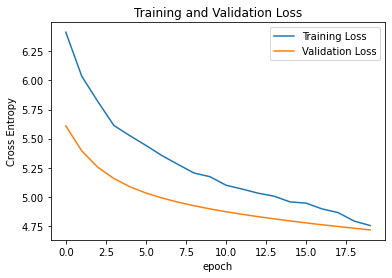

In [ ]:
# Check the loss

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can see that there is not increment happened to the validation loss and the gap between the validation loss and the training loss is also not that big, indicating that the model is not overfitting. The Top-1 Accuracy of the model is also higher comparing to the other models that we have seen before, this pre-trained model is the best one so far as it is not overfitting and the Top-1 Accuracy is higher than the other ones. Some models that we have seen might score 90% of Top-1 Accuracy but then the model is overfitting so we cannot count them in. **We will go with this latest model at the end.**

In [ ]:
model.save("/content/drive/MyDrive/AML")

# Fine-Tuning


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
#               metrics=[TopKCategoricalAccuracy(k=1)])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=[TopKCategoricalAccuracy(k=1)])


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(x_train, y_train,
                         epochs=total_epochs,
                         batch_size=8,
                         initial_epoch=history.epoch[-1],
                         validation_data=(x_test, y_test))

Epoch 20/30
593/593 [==============================] - 17s 22ms/step - loss: 4.4670 - top_k_categorical_accuracy: 0.0084 - val_loss: 4.4504 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 21/30
593/593 [==============================] - 12s 20ms/step - loss: 4.0627 - top_k_categorical_accuracy: 0.0038 - val_loss: 4.3980 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 22/30
593/593 [==============================] - 12s 20ms/step - loss: 3.7617 - top_k_categorical_accuracy: 0.0084 - val_loss: 4.2985 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 23/30
593/593 [==============================] - 12s 20ms/step - loss: 3.4942 - top_k_categorical_accuracy: 0.0082 - val_loss: 4.2259 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 24/30
593/593 [==============================] - 12s 20ms/step - loss: 3.2907 - top_k_categorical_accuracy: 0.0093 - val_loss: 4.1545 - val_top_k_categorical_accuracy: 0.0000e+00
Epoch 25/30
593/593 [==============================] - 11s 19ms/step - loss

In [ ]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

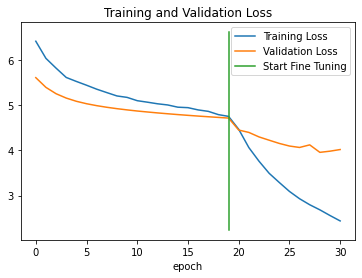

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/AML_project/Saved Models")